# Table of Contents
  - 1 [Prelude](#Prelude)
  - 2 [Utilities](#-as-before)
  - 3 [Finding Shortest Path as before](#Finding-Shortest-Path-as-before)
  - 4 [Finding Shortest Delivery Route as before](#Finding-Shortest-Delivery-Route-as-before)
  - 5 [Time Handling](#Time-Handling)
  - 6 [Class Recorder](#Class-Recorder)
  - 7 [Class Parcel](#Class-Parcel)
  - 8 [Class Customer](#Class-Customer)
  - 9 [Class Driver](#Class-Driver)
  - 10 [Class Delivery Centre](#Class-Delivery-Centre)
  - 11 [Simulation](#Simulation)
      - 11.1 [Parameters from Specification](#Parameters-from-Specification)
      - 11.2 [Generate Input Data](Generate-Input-Data)
      - 11.3 [Simulation Routine](#Simulation-Routine)
      - 11.4 [Model Verification](#Model-Verification)


# 1. Prelude

In [1]:
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np
import simpy

# 2. Utilities (as before)

## 2.1. Points and Distances

In [2]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

## 2.2. PlotMap

In [3]:
def plotMap(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=9,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [ W[0] ], [ W[1] ], 
                      styleW, ms=msW)
    if text is not None:
        maxX = max([p[0] for p in V])
        plt.text(0.8*maxX, 0, text)
    if grid:
        plt.grid()
    plt.show()

## 2.3. Add Targets

In [4]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## 2.4. Generate Warehouse Location 

In [5]:
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]
    return W

## 2.5 Time Handling 

**Convention** We use seconds to measure time in this project. The simulation will start at 0:00 and the Time related methods will be added as they are needed.

The simulation will start at 0:00. Time related methods will be added as they are needed.

In [6]:
  def timestamp(t):
        day = int(t)//(24*3600)
        t = t - day*24*3600
        hour = int(t)//3600
        t = t - hour*3600
        mins = int(t)//60
        t = t - mins*60
        secs = int(t)
        t = int(round((t - secs)*10))
        return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [7]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [8]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [9]:
def day(now):
    return int(now//(24*3600))

# 3. Finding Shortest Path (as before)

In [10]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [11]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [12]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

# 4. Finding Shortest Delivery Route (as before)

## 4.1 Iterative Integer Programming 

In [13]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [14]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [15]:
def createLoop(M, T, timing=False):
    
    if timing:
        start_time = time.time()
        last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)

    if n==1:
        return T
        
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()

    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
        prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
        
    trip = trips[0]
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

## 4.2 Heuristic Algorithm

In [16]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

In [36]:
def createLoopH(M, T, timing=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
        
    if timing:
        start_time = time.time()
        last_time = time.time()
        
    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            
    if timing:
        print(f"createLoopH:    {time.time()-start_time:6.2f}s")

    return makeLoop(L)
   
def shortcut2(roundtrip):
    #Attempt to shorten the route by reversing segments of the route.
    n = len(roundtrip)
    best_route = roundtrip[:]
    for i in range(n - 1):
        for j in range(i + 2, n):  # ensure at least one node between i and j
            new_route = roundtrip[:i+1] + list(reversed(roundtrip[i+1:j+1])) + roundtrip[j+1:]
            if calculate_total_distance(new_route) < calculate_total_distance(best_route):
                best_route = new_route
    return best_route

def shortcut3(roundtrip):
    #Attempt to improve the route by repositioning nodes.
    n = len(roundtrip)
    best_route = roundtrip[:]
    for i in range(1, n - 1):
        for j in range(n):
            if j != i and j != i + 1:  # Prevents index errors and unnecessary swaps
                new_route = roundtrip[:i] + roundtrip[i+1:]
                new_route.insert(j, roundtrip[i])
                if calculate_total_distance(new_route) < calculate_total_distance(best_route):
                    best_route = new_route
    return best_route

def calculate_total_distance(route):
    #Calculate the total distance of a route using the dist function.
    return sum(dist(route[i], route[i + 1]) for i in range(len(route) - 1))

# 5. Class Recorder

We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder.

In [18]:
import time

class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot

        self.timing = timing
        self.start_time = time.time()
        self.last_time = self.start_time
        self.cum_timer = {}
            
        Customer.REGISTER = []
        Parcel.REGISTER = []
    
    def timer(self, s):
        t = time.time()
        Δt = t-self.last_time
        if self.timing:
            print(f"==== t: {t-self.start_time:6.2f}s "
                  f"Δt: {Δt:6.2f}s [{s:s}]")
        if s in self.cum_timer:
            self.cum_timer[s] += Δt
        else:
            self.cum_timer[s] = Δt
        self.last_time = t

    def reportTimer(self):
        print()
        for k in sorted(self.cum_timer, key=lambda x: self.cum_timer[x], reverse=True):
            print(f"==== Σ: {self.cum_timer[k]:6.2f}s [{k:s}]")
        print(f"==== -----------------------")
        print(f"==== Σ: {time.time()-self.start_time:6.2f}s Total")
 
    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def finish(self):
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None

# 6. Class Parcel 

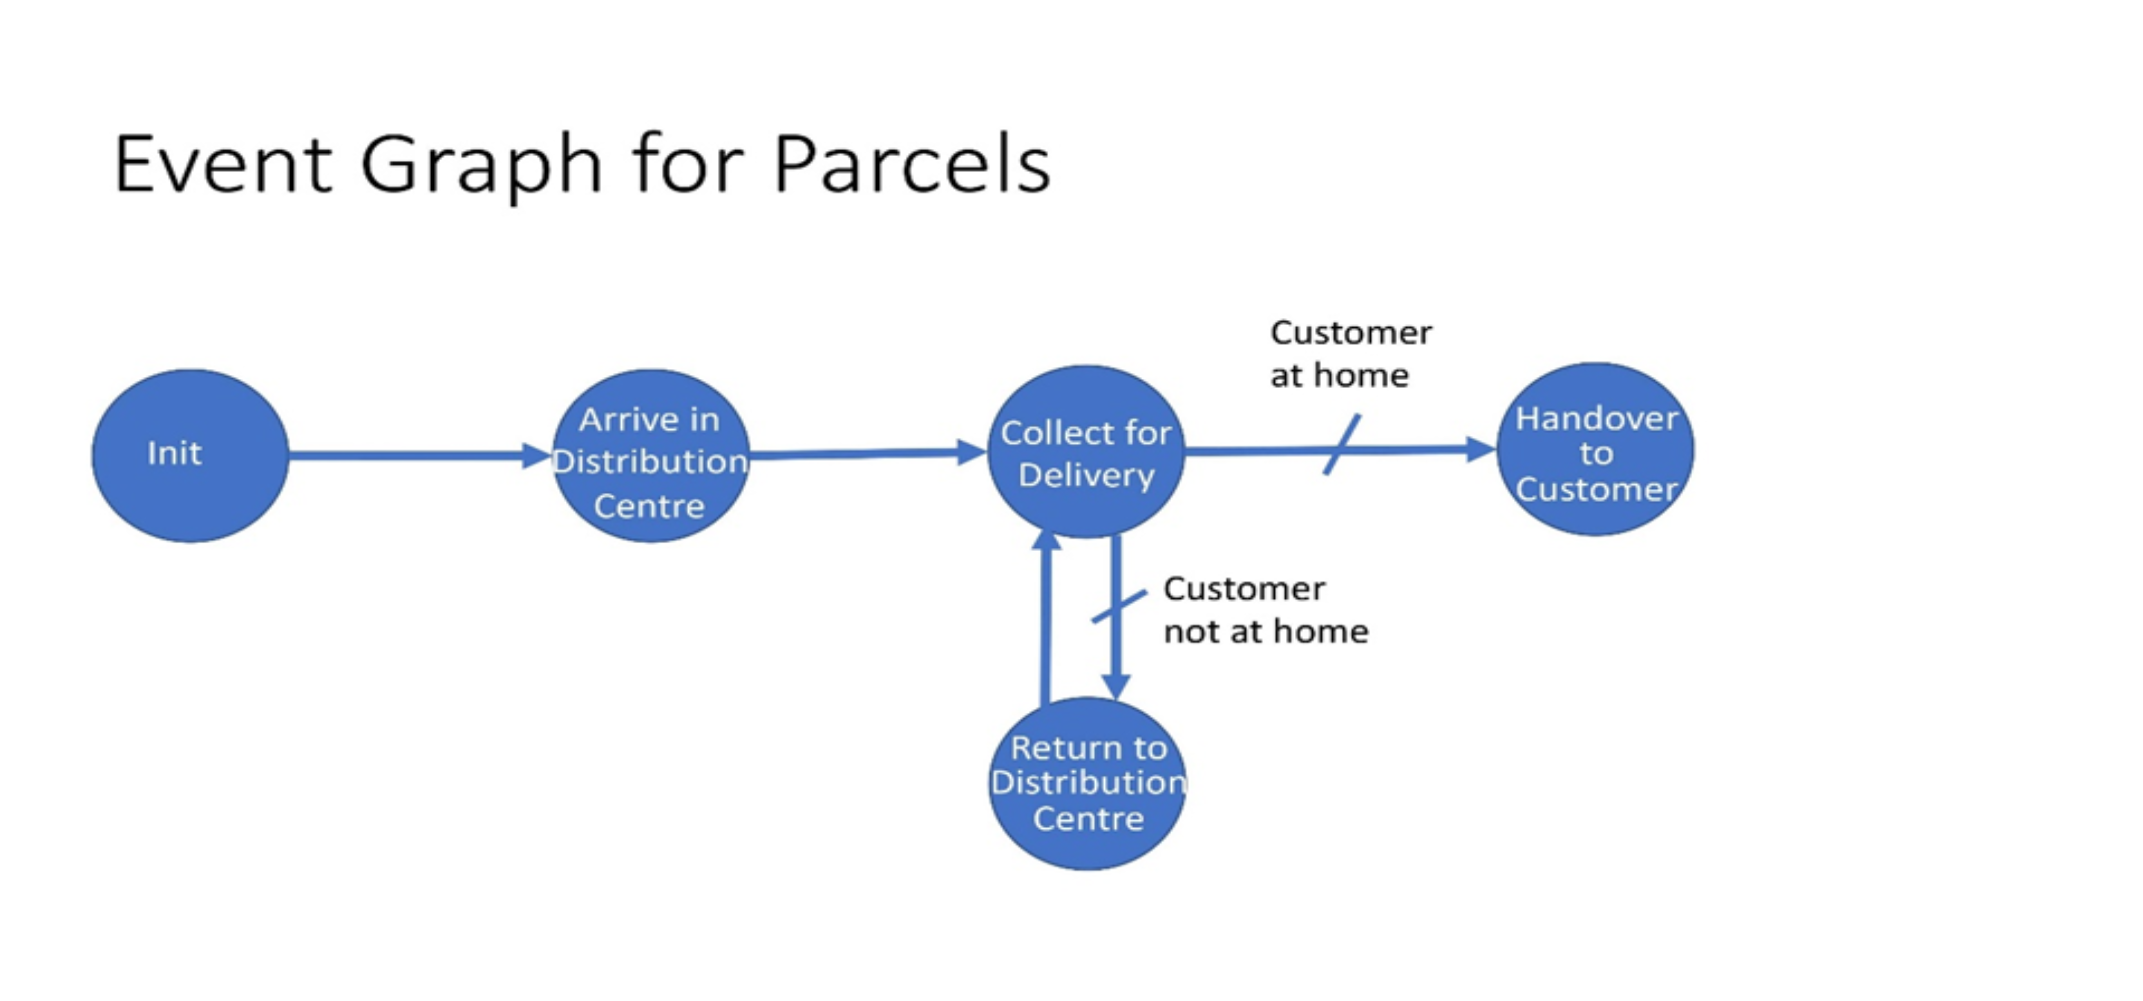

Parcels follow through a sequence of states:

 - Processing 
 - in transit (from manufacture to distribution centre)
 - arrived in distibution centre
 - ready for delivery
 - out for delivery
 - customer not present
 - return to distribution centre
 - delivered

In [19]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust, custIndex):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.custIndex = custIndex
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 
    
    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location, custIndex):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location, custIndex)

    
    def __str__(self):
        return f"Parcel: {self.i:3d} ({self.custIndex:3d})"

    def index(self):
        return self.i
    
    def destination(self):
        return self.dest
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')

# 7. Class Customer

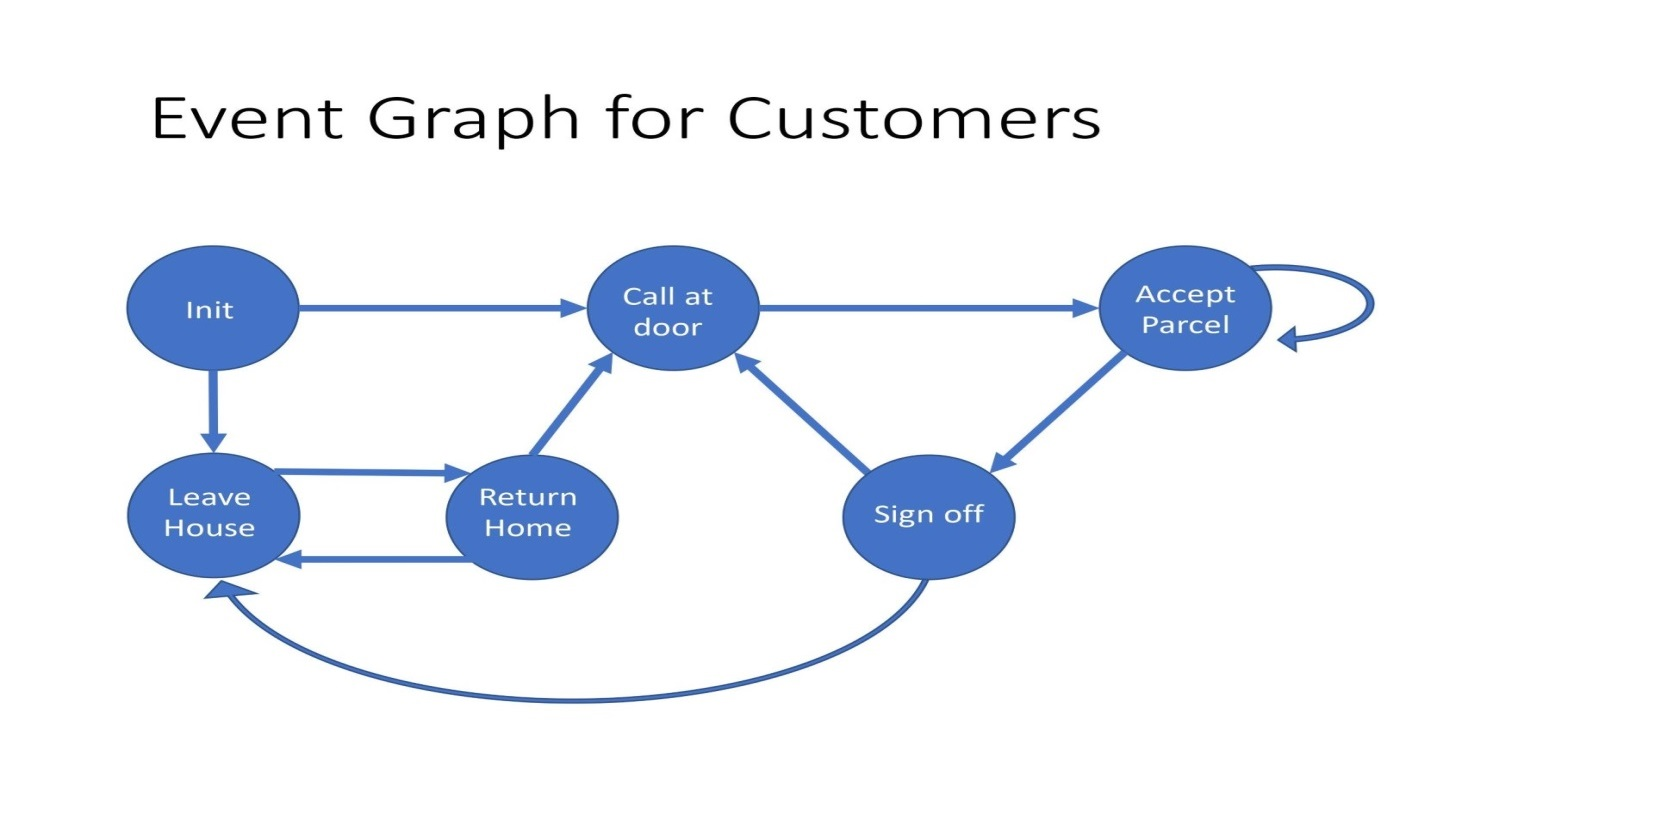 

In [20]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.trace(str(self)+" accepts "+str(parcel))
        
    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

# 8. Class Driver

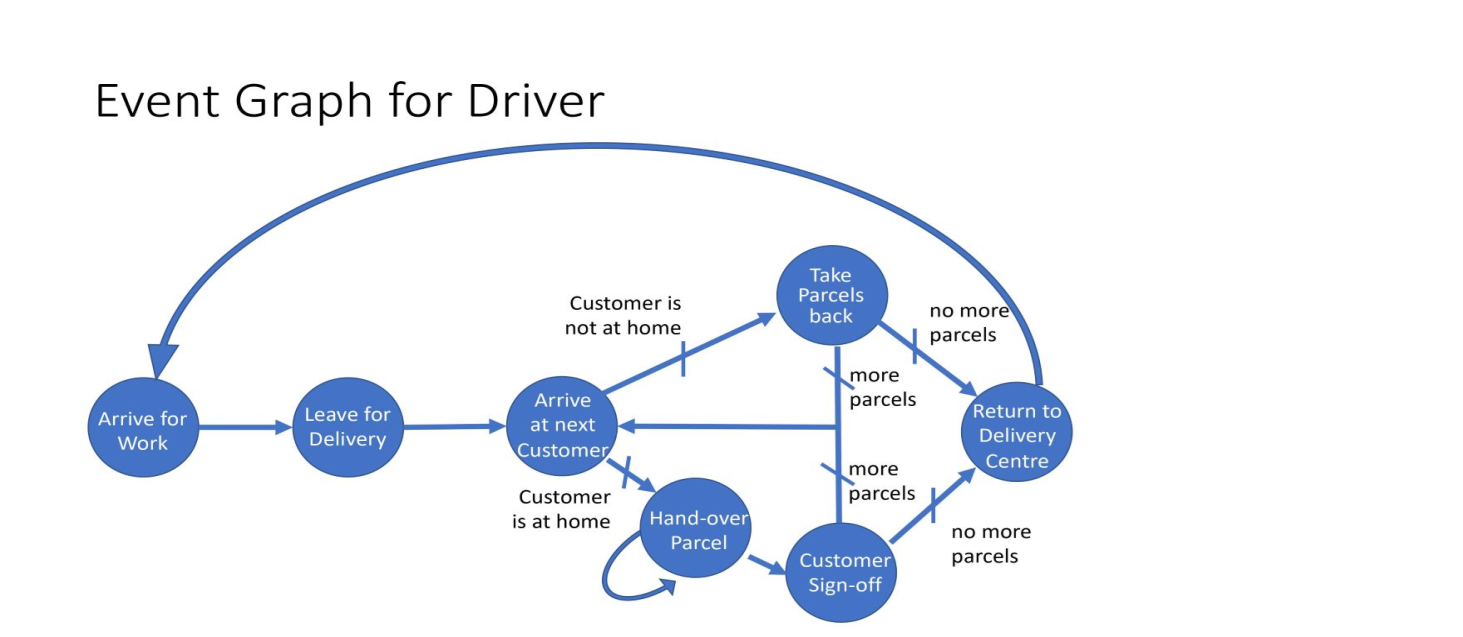

In [21]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.trace("Driver arrives for work")
        
    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            self.leaveForDelivery(tour, parcels)        
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()
                
                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        cust.acceptParcel(self.parcels[0])
                        yield self.rec.env.timeout(random.expovariate(1/10))
                        self.parcels = self.parcels[1:]
                    cust.signOff()
                    yield self.rec.env.timeout(random.expovariate(1/10))
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            self.rec.trace("Driver arrived at delivery centre")
            
            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)
        
            self.rec.trace("Driver goes home")
            
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

# 9. Class Delivery Centre

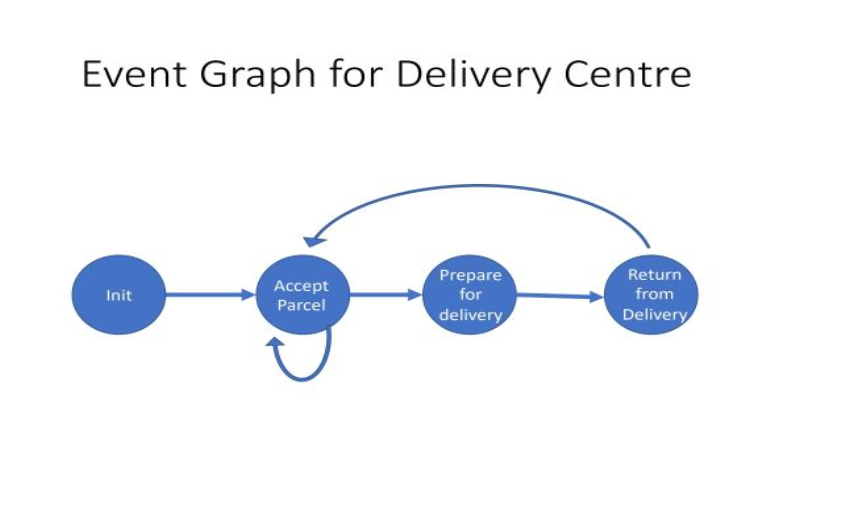

In [22]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = 40000
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = None      # tour planned for delivery
    
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc not in self.dest:
            MT = addTargets(self.M, self.dest + [custLoc])
            self.rec.timer("addTarget")
            SH = createLoopH(MT, [self.W] + self.dest + [custLoc], 
                             timing=self.rec.timing)
            self.rec.timer("createLoopH")
            if self.tour is None and pathLength(SH)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
            else: 
                S = createLoop(MT, [self.W] + self.dest + [custLoc], 
                               timing=self.rec.timing)
                self.rec.timer("createLoop")
                if pathLength(S)<self.limit:
                    self.parcels.append(parcel)
                    self.dest += [custLoc]
                    self.tour = S
                else:
                    self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        if self.tour is None:
            MT = addTargets(self.M, self.dest)
            self.rec.timer("addTarget")
            self.tour = createLoop(MT, [self.W] + self.dest, 
                                   timing=self.rec.timing)
            self.rec.timer("createLoop")
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest and p not in parcels:
                    parcels += [p]
                    p.outForDelivery()
         
        # arrange the left overs
        L = self.leftOver
        self.tour = None
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, W=tour[0], 
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

    def getInventory(self):
        return len(self.parcels)+len(self.leftOver)

# 10. Simulation

## 10.1. Parameters from Specification

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [23]:
AVERAGE_SPEED = 15/3.6

**The cumulative preparation time** (route planning and sorting of the parcels in the
delivery order and packing the cargo-bike)

In [24]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parcel.

In [25]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [26]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [27]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

# 10.2. Generate Input Data

In [28]:
def generateDeliveryData(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    np.random.seed(seed)
    R = np.random.poisson(lam=len(C)*p, size=days)
    D = [ sorted(list(np.random.choice(range(len(C)), size=i))) for i in R ]
    return D

In [29]:
def generateInputData(D, log=False):

    R = [ len(d) for d in D ]
    N = sum(R)
    
    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    last_time = 0
    i = 0

    for d in D: # for each day

        if log:
            print("generating for day: ",current_day, D[current_day])
            
        time = current_day*DAY_LENGTH + DAY_START 

        for c in d: # for each customer that should get a 

            IARR = (DAY_END-DAY_START-2*3600) / len(d)  # estimated average IAT for the current day

            iat = random.expovariate(1.0/IARR)
            new_time = time + iat

            x.at[i, 'iarr'] = round(new_time - last_time,1)
            x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
            x.at[i, 'day'] = current_day
            x.at[i, 'dest'] = c
            
            i += 1
            last_time = time = new_time
    
        current_day += 1
    
    return x

# 10.3. Simulation Routine

In [30]:
def simulation(M, W, C, p=0.15, days=20, seed=5640, 
               log=False, plot=False, timing=False):

    random.seed(seed)
    D = generateDeliveryData(p, C, days, seed)
    X = generateInputData(D, log=log)
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, 
                   log=log, plot=plot, timing=timing)

    print(f"Simulating delivery of {len(X):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers")

    for c in C:
        Customer.getCustomer(rec, c)           
    DC = DeliveryCentre(rec, M, W)
    D = Driver(rec, DC)

    def generatorProcess(env):
        # generate the parcels based on input data x
        for i in range(len(X)):
            yield env.timeout(X.at[i, 'iarr'])
            custIndex = X.at[i, 'dest']
            custLoc = C[custIndex]
            cust = Customer.getCustomer(rec, custLoc)
            p = Parcel.getParcel(rec, i, cust, custIndex)
            DC.acceptParcel(p)

    env.process(generatorProcess(env))
    env.run()

    rec.finish()

    if log:
        print(f"Delivery Centre Inventory: {DC.getInventory():d} parcels")

    return rec

# 10.4. Model Verification 

In [31]:
import pickle
with open('myData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [40]:
random.seed(5640)
W = generateWarehouseLocation(M)
rec = simulation(M, W, C, p=0.15, days=20, log=True)
rec.reportTimer()

generating for day:  0 [3, 16]
generating for day:  1 [2]
generating for day:  2 [6, 6]
generating for day:  3 [4]
generating for day:  4 [14, 17]
generating for day:  5 [4, 15]
generating for day:  6 [2, 11, 12, 12, 17, 19]
generating for day:  7 [5, 6, 13, 16, 19]
generating for day:  8 [4, 19]
generating for day:  9 [0, 1, 7, 11, 19]
generating for day:  10 [10, 11, 13, 16, 19]
generating for day:  11 [3, 8, 10, 16]
generating for day:  12 [7, 14, 15]
generating for day:  13 [9, 14, 16, 17]
generating for day:  14 [4, 6, 9]
generating for day:  15 [6, 10]
generating for day:  16 [6, 15, 15]
generating for day:  17 [14]
generating for day:  18 [15, 17]
generating for day:  19 [0, 8]
Simulating delivery of 57 parcels over 20 days to 20 customers
[ 0] 10:30:48.3 Parcel:   0 (  3) arr at delivery centre
[ 0] 12:09:16.8 Parcel:   1 ( 16) arr at delivery centre
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Parcel:   0 (  3) out for delivery
[ 0] 18:00:00.0 Parcel:   1 ( 16) out 

In [33]:
rec1 = simulation(M, W, C, p=0.15, days=20, log=True, timing=True)
rec1.reportTimer()

generating for day:  0 [3, 16]
generating for day:  1 [2]
generating for day:  2 [6, 6]
generating for day:  3 [4]
generating for day:  4 [14, 17]
generating for day:  5 [4, 15]
generating for day:  6 [2, 11, 12, 12, 17, 19]
generating for day:  7 [5, 6, 13, 16, 19]
generating for day:  8 [4, 19]
generating for day:  9 [0, 1, 7, 11, 19]
generating for day:  10 [10, 11, 13, 16, 19]
generating for day:  11 [3, 8, 10, 16]
generating for day:  12 [7, 14, 15]
generating for day:  13 [9, 14, 16, 17]
generating for day:  14 [4, 6, 9]
generating for day:  15 [6, 10]
generating for day:  16 [6, 15, 15]
generating for day:  17 [14]
generating for day:  18 [15, 17]
generating for day:  19 [0, 8]
Simulating delivery of 57 parcels over 20 days to 20 customers
[ 0] 10:30:48.3 Parcel:   0 (  3) arr at delivery centre
==== t:   0.00s Δt:   0.00s [addTarget]
createTables:     0.01s
createLoopH:      0.01s
==== t:   0.01s Δt:   0.01s [createLoopH]
[ 0] 12:09:16.8 Parcel:   1 ( 16) arr at delivery centre

In [34]:
rec2 = simulation(M, W, C, p=0.15, days=20, log=False, timing=True)
rec2.reportTimer()

Simulating delivery of 57 parcels over 20 days to 20 customers
==== t:   0.00s Δt:   0.00s [addTarget]
createTables:     0.01s
createLoopH:      0.01s
==== t:   0.01s Δt:   0.01s [createLoopH]
==== t:   0.01s Δt:   0.00s [addTarget]
createTables:     0.01s
createLoopH:      0.01s
==== t:   0.02s Δt:   0.01s [createLoopH]
==== t:   0.02s Δt:   0.00s [addTarget]
createTables:     0.00s
Solver:           0.05s     12 Constraints
createLoop:       0.05s
==== t:   0.07s Δt:   0.05s [createLoop]
==== t:   0.07s Δt:   0.00s [addTarget]
createTables:     0.00s
==== t:   0.07s Δt:   0.00s [createLoop]
==== t:   0.07s Δt:   0.00s [addTarget]
createTables:     0.01s
createLoopH:      0.01s
==== t:   0.08s Δt:   0.01s [createLoopH]
==== t:   0.08s Δt:   0.00s [addTarget]
createTables:     0.01s
createLoopH:      0.01s
==== t:   0.09s Δt:   0.01s [createLoopH]
==== t:   0.09s Δt:   0.00s [addTarget]
createTables:     0.00s
Solver:           0.04s     12 Constraints
createLoop:       0.04s
==== t:  

In [35]:
rec3 = simulation(M, W, C, p=0.15, days=20)
rec3.reportTimer()

Simulating delivery of 57 parcels over 20 days to 20 customers

==== Σ:   0.92s [createLoop]
==== Σ:   0.56s [createLoopH]
==== Σ:   0.01s [addTarget]
==== -----------------------
==== Σ:   1.48s Total
